<a href="https://colab.research.google.com/github/EdBerg21/AI-Professional-Prompts/blob/main/004_MINE_13_chat_with_multiple_pdfs_using_llama_2_and_langchain_ipynb_txt_ipynb_txt_ipynb_txt_ipynb_txt_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Feb 14 23:16:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchvision 0.16.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.

In [ ]:
!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl

In [ ]:
!pip install -qqq auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 1s (366 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121749 

In [ ]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data

In [ ]:
!mkdir pdfs

Quais são as atribuições e competências conferidas ao CONAMA pela Lei nº 6.938/1981?

Por que é importante incorporar instrumentos de gestão ambiental ao sistema de licenciamento?

Quais são as diretrizes estabelecidas na Resolução CONAMA nº 11/94 em relação ao licenciamento ambiental?

In [ ]:
!gdown 1v-Rn1FVU1pLTAQEgm0N9oB6cExMoebZr -O pdfs/tesla-earnings-report.pdf
!gdown 1Xc890jrQvCExAkryVWAttsv1DBLdVefN -O pdfs/nvidia-earnings-report.pdf
!gdown 1Epz-SQ3idPpoz75GlTzzomag8gplzLv8 -O pdfs/meta-earnings-report.pdf

Downloading...
From: https://drive.google.com/uc?id=1v-Rn1FVU1pLTAQEgm0N9oB6cExMoebZr
To: /content/pdfs/tesla-earnings-report.pdf
100% 345k/345k [00:00<00:00, 4.18MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xc890jrQvCExAkryVWAttsv1DBLdVefN
To: /content/pdfs/nvidia-earnings-report.pdf
100% 414k/414k [00:00<00:00, 4.63MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Epz-SQ3idPpoz75GlTzzomag8gplzLv8
To: /content/pdfs/meta-earnings-report.pdf
100% 183k/183k [00:00<00:00, 3.07MB/s]


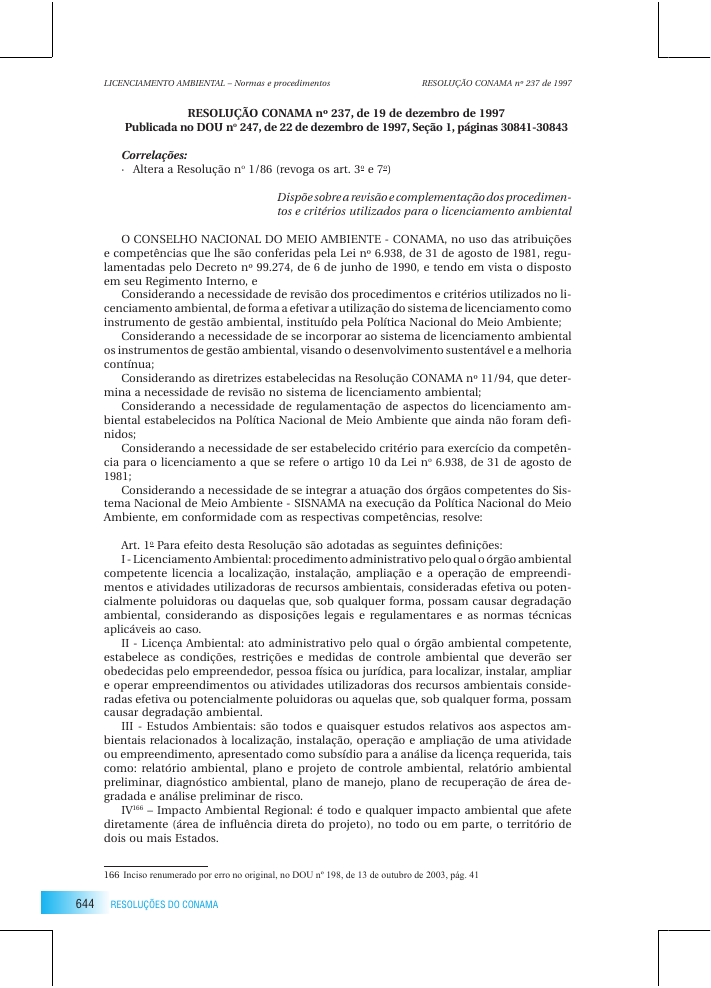

In [ ]:
meta_images = convert_from_path("pdfs/CONAMA_RES_CONS_1997_237.pdf", dpi=88)
meta_images[0]

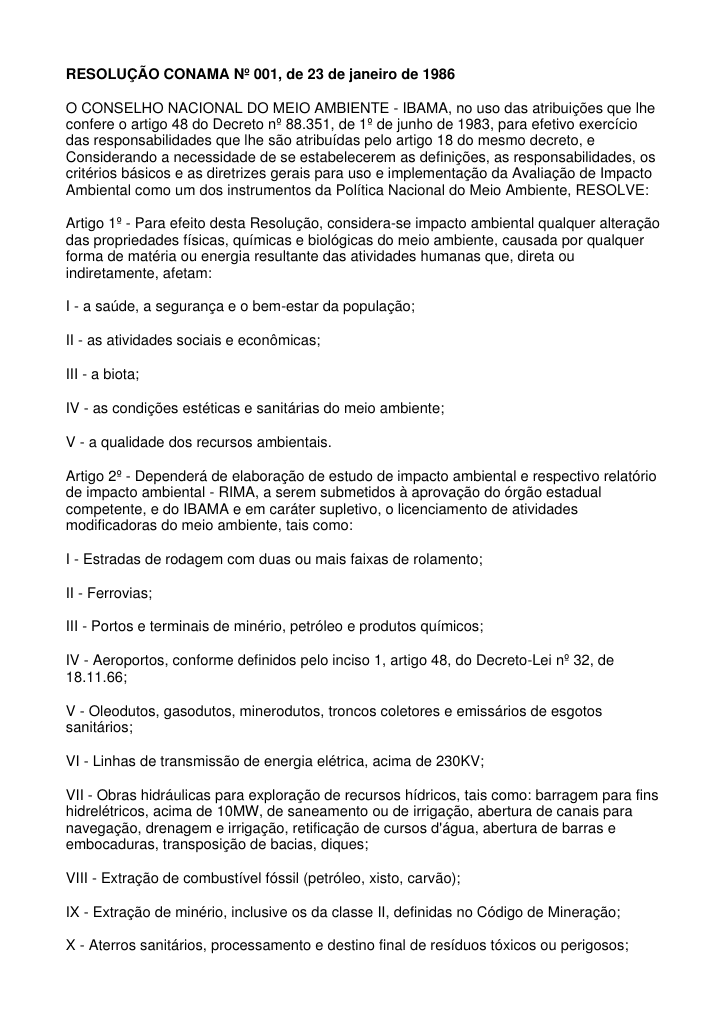

In [ ]:
nvidia_images = convert_from_path("pdfs/RE0001-230186.pdf", dpi=88)
nvidia_images[0]

In [ ]:
!rm -rf "db"

In [ ]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

14

In [ ]:
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

48

In [ ]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

CPU times: user 6.29 s, sys: 171 ms, total: 6.46 s
Wall time: 7.22 s


## Llama 2 13B

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

1. You disabled CUDA extensions compilation by setting BUILD_CUDA_EXT=0 when install auto_gptq from source.
2. You are using pytorch without CUDA support.
3. CUDA and nvcc are not installed in your device.


config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

quantize_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

In [ ]:
!nvidia-smi

Wed Feb 14 23:34:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0              29W /  70W |   8535MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer in portuguese language as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} [/INST]
""".strip()

In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [ ]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.1.0+cu121)
    Python  3.10.11 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'Marian

In [ ]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [ ]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

## Chat with Multiple PDFs

In [ ]:
result = qa_chain("Quais são as atribuições e competências conferidas ao CONAMA pela Lei nº 6.938/1981?")

 Based on the provided context, I can answer your question. According to the Resolution nº 237/1997, the CONAMA has the following attributions and competencies conferred by Law nº 6.938/1981:

1. To regulate and oversee the use of natural resources, including water and energy resources.
2. To license and monitor the implementation of activities that may affect the environment, such as construction, mining, and industrial activities.
3. To establish and enforce environmental standards and regulations.
4. To conduct inspections and audits to ensure compliance with environmental laws and regulations.
5. To investigate and penalize non-compliance with environmental laws and regulations.

These attributions and competencies are intended to ensure the effective management of the environment and the protection of natural resources, in accordance with the National Environmental Policy.


In [ ]:
len(result["source_documents"])

2

In [ ]:
print(result["source_documents"][0].page_content)

644 RESOLUÇÕES DO CONAMARESOLUÇÃO CONAMA nº 237, de 19 de dezembro de 1997
Publicada no DOU no 247, de 22 de dezembro de 1997, Seção 1, páginas 30841-30843
Correlações:
· Altera a Resolução no 1/86 (revoga os art. 3o e 7o)
Dispõe sobre a revisão e complementação dos procedimen-
tos e critérios utilizados para o licenciamento ambiental
O CONSELHO NACIONAL DO MEIO AMBIENTE - CONAMA, no uso das atribuições 
e competências que lhe são conferidas pela Lei nº 6.938, de 31 de agosto de 1981, regu-lamentadas pelo Decreto nº 99.274, de 6 de junho de 1990, e tendo em vista o disposto em seu  Regimento Interno, e
Considerando a necessidade de revisão dos procedimentos e critérios utilizados no li-
cenciamento ambiental, de forma a efetivar a  utilização do sistema de licenciamento como instrumento de gestão ambiental, instituído pela  Política   Nacional do Meio Ambiente;
Considerando a necessidade de se incorporar ao sistema de licenciamento ambiental


In [ ]:
result = qa_chain("Por que é importante incorporar instrumentos de gestão ambiental ao sistema de licenciamento?")

 Based on the provided article, it is important to incorporate instruments of environmental management into the licensing system for the following reasons:

1. To ensure the compatibility of the licensing process with the stages of planning, implementation, and operation of the activity or enterprise.
2. To take into account the nature, characteristics, and peculiarities of the activity or enterprise when establishing the licensing requirements.
3. To provide for simplified procedures for certain activities and enterprises, as determined by the competent environmental authority.

Incorporating instruments of environmental management into the licensing system helps to ensure that the licensing process is well-informed, effective, and efficient, and that it takes into account the specific needs and circumstances of each activity or enterprise. This can help to prevent negative environmental impacts, promote sustainable development, and ensure compliance with environmental laws and regula

In [28]:
result = qa_chain("Quais são as diretrizes estabelecidas na Resolução CONAMA nº 11/94 em relação ao licenciamento ambiental?")

 Based on the provided context, I can answer your question. According to the Resolution CONAMA nº 11/94, there are several directions established for the environmental licensing process. These directions include:

1. The need for revision of the system of environmental licensing to ensure the effective use of the licensing process as an instrument of environmental management.
2. The importance of incorporating instruments of environmental management into the licensing process to promote sustainable development and continuous improvement.
3. The necessity of regulating aspects of environmental licensing that have not been defined or established.
4. The need to establish criteria for the exercise of competence in granting licenses, as stated in Article 10 of Law No. 6,938/1981.
5. The integration of the action of the competent authorities of the National System of Environmental Management (SISNAMA) in the execution of the National Policy for the Environment, in accordance with their resp

In [29]:
print(result["source_documents"][1].page_content)

os instrumentos de gestão ambiental, visando o desenvolvimento sustentável e a melhoria contínua;
Considerando as diretrizes estabelecidas na Resolução CONAMA nº 11/94, que deter-
mina a necessidade de revisão no sistema de licenciamento ambiental;
Considerando a necessidade de regulamentação de aspectos do licenciamento am-
biental estabelecidos na  Política  Nacional de Meio Ambiente que ainda não foram deﬁ  -
nidos; 
Considerando a necessidade de ser estabelecido critério para exercício da competên-
cia para o licenciamento a que se refere o artigo 10 da Lei n
o 6.938, de 31 de agosto de 
1981; 
Considerando a necessidade de se integrar a atuação dos órgãos competentes do  Sis-
tema  Nacional de Meio Ambiente - SISNAMA na execução da  Política   Nacional do Meio Ambiente, em conformidade com as respectivas competências, resolve:
Art. 1
o Para efeito desta Resolução são adotadas as seguintes deﬁ  nições:
I - Licenciamento   Ambiental: procedimento administrativo pelo qual o órgão amb

In [30]:
result = qa_chain("Faça um resumo da resolução CONAMA pela Lei nº 6.938/1981??")

 Based on the provided context, I cannot provide a summary of the resolution CONAMA by Law No. 6,938/1981, as there is no mention of this law in the given text. The resolutions mentioned are CONAMA Resolution No. 237/1997 and CONAMA Resolution No. 001-A/1986.


In [31]:
result = qa_chain("Provide a summary of the text")

 Based on the provided text, here is a summary:

The text describes the activities and services offered by Fumo Industries, which include construction, civil works, energy production, and waste treatment. The company provides various solutions for infrastructure development, including transportation, logistics, and environmental management. The text also outlines the impact assessment requirements for the projects, including the objectives and justifications, technical description, and compatibility with government policies and programs.


In [ ]:
result = qa_chain("Faça um resumo listando os itens da resolução CONAMA")

 Based on the provided context, I can answer the question as follows:

The resolution CONAMA No. 237, dated December 19, 1997, includes the following items:

1. Alters Resolution No. 1/86 by revoking Articles 3 and 7.
2. Disposes new procedures and criteria for environmental licensing.
3. Revises and complements the existing licensing processes and criteria.
4. Incorporates the system of licensing 

In [ ]:
result = qa_chain(
    "Faça uma lista de 10 perguntas sobre as diretrizes estabelecidas na Resolução CONAMA nº 11/94
"
)

In [ ]:
result = qa_chain(
    "Choose one company to invest (Tesla, Nvidia or Meta) to maximize your profits for the long term (10+ years)?"
)

## References

- [Tesla Quarterly Report (Jul 21, 2023)](https://ir.tesla.com/_flysystem/s3/sec/000095017023033872/tsla-20230630-gen.pdf)
- [Meta Q2 2023 Earnings (Jul 26, 2023)](https://s21.q4cdn.com/399680738/files/doc_financials/2023/q2/Meta-06-30-2023-Exhibit-99-1-FINAL.pdf)
- [Nvidia Fiscal Q1 2024](https://s201.q4cdn.com/141608511/files/doc_financials/2024/q1/ecefb2b2-efcb-45f3-b72b-212d90fcd873.pdf)